In [ ]:
import math
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Functions

In [ ]:
def str_to_int_SW(datax):
    dataclass=datax[0]
    fclass=0
    if   dataclass=='A':
        fclass=1
    elif dataclass=='B':
        fclass=2
    elif dataclass=='C':
        fclass=3
    elif dataclass=='M':
        fclass=4
    elif dataclass=='X':
        fclass=5
    return fclass

In [ ]:
def transform_flare_mid_SW(dataset,tavan_map=8):
    dataset = pd.DataFrame(dataset,columns=['peak_flux'])
    dataset = pd.DataFrame(dataset).rename(columns={'peak_flux': 'data'})

    conditions0, class_map1,class_mapnum = split_part_SW(n=10, tavan=8,tavan_map=tavan_map)

    ddd = conditions_fun_SW(dataset['data'], conditions0)

    dataset['new_value'] = np.select(np.array(ddd), class_map1)
    dataset['new_value_num'] = np.select(np.array(ddd), class_mapnum)

    return dataset

def split_part_SW(tavan=4,n=10,tavan_map=8):
    interval1, conditions ,class_map,idk,class_map_num= [], [],[],0,[]
    for jdx in range(tavan,3,-1):
        sx=10 ** (-jdx)
        distance = (sx * 10 - sx) / n
        l ,map_part= sx,(sx+(distance/2))
        if idk==0:
            interval1.append(sx)
        for idx in range(n):
            l += distance
            interval1.append(l)
            if (idk==0):
                part = [-math.inf, interval1[idk + 1]]
            elif (idk==((tavan-2)*n-1)):
                part = [interval1[idk], math.inf]
            else:
                part = [interval1[idk], interval1[idk + 1]]

            conditions.append(part)
            class_map.append(map_part*10**(tavan_map))
            class_map_num.append(idk+1)
            map_part += (distance)
            idk+=1
    return (conditions,class_map,class_map_num)
def conditions_fun_SW(dataset,conditions0):
    conditions01=pd.DataFrame()
    for idx in range(len(conditions0)):
        dataset0=(dataset > conditions0[idx][0]) & (dataset <= conditions0[idx][1])
        conditions01[idx]=dataset0
    conditions01=conditions01.transpose()
    return conditions01

In [ ]:
def get_data(df_first,tavan_map=8):
  df_first['fclass1'] = df_first['fclass'].astype(str).str[0:1]  # keep first value class such as A,B,...
  df_first['fclass2'] = [str_to_int_SW(x) for x in df_first['fclass1']]  #  value class such as 1,2,3,...

  df = transform_flare_mid_SW(df_first['peak_flux'], tavan_map=tavan_map)
  df_first['peak_flux_new']=df['new_value']

  #                                                  convert time to int
  df_first['tstart'] = pd.to_datetime(df_first['tstart'])
  df_first['tpeak'] = pd.to_datetime(df_first['tpeak'])
  df_first['tend'] = pd.to_datetime(df_first['tend'])


  features = ['tstart', 'tpeak', 'tend',  'peak_flux_new', 'fclass2']
  return df_first[features]

In [ ]:
def print_num_class(next_value,max_class=5,flag_disply=True):
    num_class = []
    for i in range(0,max_class+1):
        d_result=np.array(next_value == i)
        num_class.append(sum(d_result))
    if flag_disply:
        print(' \t'*6,' num_class:', num_class)
    return num_class

In [ ]:
def DifTime_SF(df_first):
    df_first=df_first.reset_index()
    df_first=df_first.rename(columns={'0': 'tstart'})
    print('\t\t\t -------\t ------- \t \t Calculating times_diff  \n')

    df_first['tstart'] = pd.to_datetime(df_first['tstart'])
    df_first['tstart1'] = [time.date().year for time in df_first['tstart']]

    df_first['times_diff'] = df_first['tpeak'].diff().dropna()
    df_first['times_diff']=[x.total_seconds() for x in df_first['times_diff']]

    print('len(df_first)',len(df_first))
    return df_first[['times_diff']]

In [ ]:
def create_SW_2d(dataset,window_size,over_sampling=0):
    data=(dataset[dataset.columns[:-1]])
    class_data=dataset[dataset.columns[-1]]

    if len(np.unique(class_data))==5:
        k_class=3
    else:
        k_class=1
    windows,next_value,next_class ,over_data = [],[],[],[]
    print('\t'*9,'Sliding Windows',np.unique(class_data))
    aaa=[]
    if( over_sampling >0 ):
        over_sampling -= 1

    for i_data in range(window_size, len(data)):
        if (class_data.iloc[i_data]>k_class):
            for i_k in range(over_sampling+1):
                windows_pas=np.array(data.iloc[i_data - window_size:i_data])
                windows.append(windows_pas)
                next_value.append(data.iloc[i_data])
                next_class.append(class_data.iloc[i_data])
                if i_k == 0:
                    over_data.append(0)
                else:
                    over_data.append(1)
            aaa.append(class_data.iloc[i_data])
        else:
            windows_pas = np.array(data.iloc[i_data - window_size:i_data])
            windows.append(windows_pas)

            next_value.append(data.iloc[i_data])
            next_class.append(class_data.iloc[i_data])
            over_data.append(0)

    print('over sampling for ',np.unique(aaa))
    windows_a = np.stack(windows)
    print('size SW, class: ',windows_a.shape,np.shape(next_class))
    return windows_a,next_value,next_class,over_data

# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename='/content/drive/MyDrive/1403/SF/FlareList_2003-2023.csv'
df_SF = pd.read_csv(filename)
len(df_SF)

151071

In [ ]:
#                       -------------------   -------------------   1-1 get data
df_first=get_data(df_SF,tavan_map=0)
df_first

,tstart,tpeak,tend,peak_flux_new,fclass2
0,2003-01-11 00:04:28,2003-01-11 00:16:16,2003-01-11 00:22:28,0.000003,3
1,2003-01-11 00:22:28,2003-01-11 00:43:28,2003-01-11 01:16:04,0.000003,3
2,2003-01-11 01:16:04,2003-01-11 01:18:16,2003-01-11 01:25:28,0.000002,3
3,2003-01-11 02:04:04,2003-01-11 02:12:52,2003-01-11 02:50:40,0.000001,3
4,2003-01-11 02:50:40,2003-01-11 02:56:52,2003-01-11 03:18:40,0.000001,3
...,...,...,...,...,...
151066,2023-04-30 21:25:28,2023-04-30 21:36:40,2023-04-30 22:19:28,0.000005,3
151067,2023-04-30 22:35:28,2023-04-30 22:41:04,2023-04-30 22:46:40,0.000001,3
151068,2023-04-30 22:46:40,2023-04-30 22:52:04,2023-04-30 23:04:28,0.000001,3
151069,2023-04-30 23:04:28,2023-04-30 23:29:28,2023-04-30 23:30:40,0.000001,3


In [ ]:
print_num_class(df_first['fclass2'])

 	 	 	 	 	 	  num_class: [np.int64(0), np.int64(2800), np.int64(85724), np.int64(59995), np.int64(2382), np.int64(170)]


[np.int64(0),
 np.int64(2800),
 np.int64(85724),
 np.int64(59995),
 np.int64(2382),
 np.int64(170)]

In [ ]:
df_first['times_diff']=DifTime_SF(df_first)
df_first

			 -------	 ------- 	 	 Calculating times_diff  

len(df_first) 151071


<ipython-input-29-f8f28763b6d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first['times_diff']=DifTime_SF(df_first)


,tstart,tpeak,tend,peak_flux_new,fclass2,times_diff
0,2003-01-11 00:04:28,2003-01-11 00:16:16,2003-01-11 00:22:28,0.000003,3,NaN
1,2003-01-11 00:22:28,2003-01-11 00:43:28,2003-01-11 01:16:04,0.000003,3,1632.0
2,2003-01-11 01:16:04,2003-01-11 01:18:16,2003-01-11 01:25:28,0.000002,3,2088.0
3,2003-01-11 02:04:04,2003-01-11 02:12:52,2003-01-11 02:50:40,0.000001,3,3276.0
4,2003-01-11 02:50:40,2003-01-11 02:56:52,2003-01-11 03:18:40,0.000001,3,2640.0
...,...,...,...,...,...,...
151066,2023-04-30 21:25:28,2023-04-30 21:36:40,2023-04-30 22:19:28,0.000005,3,4116.0
151067,2023-04-30 22:35:28,2023-04-30 22:41:04,2023-04-30 22:46:40,0.000001,3,3864.0
151068,2023-04-30 22:46:40,2023-04-30 22:52:04,2023-04-30 23:04:28,0.000001,3,660.0
151069,2023-04-30 23:04:28,2023-04-30 23:29:28,2023-04-30 23:30:40,0.000001,3,2244.0


In [ ]:
features = ['peak_flux_new', 'times_diff', 'fclass2']
df=df_first[features].iloc[1:]  #   remove null value because calculate 'times_diff'
print('\t'*5,features,df.shape, features)
df

					 ['peak_flux_new', 'times_diff', 'fclass2'] (151070, 3) ['peak_flux_new', 'times_diff', 'fclass2']


,peak_flux_new,times_diff,fclass2
1,0.000003,1632.0,3
2,0.000002,2088.0,3
3,0.000001,3276.0,3
4,0.000001,2640.0,3
5,0.000001,1596.0,3
...,...,...,...
151066,0.000005,4116.0,3
151067,0.000001,3864.0,3
151068,0.000001,660.0,3
151069,0.000001,2244.0,3


In [ ]:
#                       -------------------   -------------------   1-2 normalization
for i_f in range(len(df.columns)-1):
    name_clm = df.columns[i_f]
    df[name_clm] = ((df[name_clm] - np.min(df[name_clm]))
                          / (np.max(df[name_clm]) - np.min(df[name_clm])))
df

,peak_flux_new,times_diff,fclass2
1,0.003757,0.000163,3
2,0.002717,0.000210,3
3,0.001676,0.000331,3
4,0.001676,0.000266,3
5,0.001676,0.000160,3
...,...,...,...
151066,0.005838,0.000417,3
151067,0.001676,0.000392,3
151068,0.001676,0.000064,3
151069,0.001676,0.000226,3


# Oversampling Sliding window

In [ ]:
binray_class=4
over_sampling=12
window_size=24
kfold=4

In [ ]:
#                       -------------------   -------------------   1-3 Sliding windows
df_W, next_value, next_class,over_data = create_SW_2d(df, window_size, over_sampling=over_sampling)

next_value = pd.DataFrame(next_value)
next_class = pd.DataFrame(next_class)
over_data = pd.DataFrame(over_data)
next_value = next_value.reset_index(drop=True)

print(df_W.shape, (next_value.shape), (next_class.shape), (over_data.shape))

print('---   ............... ' * 6)
print(np.unique(next_class))
print_num_class(next_class,max_class=6)

next_class.loc[next_class[next_class.columns[0]] < binray_class] = 1
next_class.loc[next_class[next_class.columns[0]] >= binray_class] = 2
print(np.unique(next_class))
print_num_class(next_class)
print('---   ............... ' * 6)

									 Sliding Windows [1 2 3 4 5]
over sampling for  [4 5]
size SW, class:  (179118, 24, 2) (179118,)
(179118, 24, 2) (179118, 2) (179118, 1) (179118, 1)
---   ............... ---   ............... ---   ............... ---   ............... ---   ............... ---   ............... 
[1 2 3 4 5]
 	 	 	 	 	 	  num_class: [array([0]), array([2800]), array([85724]), array([59970]), array([28584]), array([2040]), array([0])]
[1 2]
 	 	 	 	 	 	  num_class: [array([0]), array([148494]), array([30624]), array([0]), array([0]), array([0])]
---   ............... ---   ............... ---   ............... ---   ............... ---   ............... ---   ............... 


# Function Deep learning

In [ ]:
from tensorflow.keras import losses
from keras.layers import Dense, LSTM, Input
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score,roc_curve

class DecompositionBlock(layers.Layer):
    def __init__(self, kernel_size):
        super(DecompositionBlock, self).__init__()
        self.kernel_size = kernel_size
        self.pool = layers.AveragePooling1D(pool_size=self.kernel_size, strides=1, padding='same')

    def call(self, x):
        Trend = self.pool(x)  # Average pooling to get moving average
        seasonal = x - Trend
        return Trend, seasonal

In [ ]:
def model_kfold_SF(data_sam,next_sam,input_f = 2,ep=2,bs=120,
                       path_file=['SF_SS_2003', 1, 12],model_name='LSTM'):

    #-------------------------------------------------------- kfold_model
    result_model_kf, result_F_kf=[],[]
    cm_all_kf=pd.DataFrame()

    test_data_len = int(len(next_sam) * 0.2)
    tscv = TimeSeriesSplit(n_splits=kfold, test_size=test_data_len)
    next_sam = np.subtract(next_sam, 1)

    max_ifold,max_tss=0,0
    for i_fold, (train_index, test_index) in enumerate(tscv.split(next_sam)):
        print('--  '*5,'i_fold:',i_fold,max_ifold)

        y_train_class, y_test_class = next_sam.loc[train_index], next_sam.loc[test_index]
        X_train, X_test = data_sam[train_index], data_sam[test_index]

        y_train_class = np.reshape(y_train_class, (y_train_class.shape[0], 1, 1))
        y_test_class = np.reshape(y_test_class, (y_test_class.shape[0], 1, 1))


        print_num_class(y_train_class)
        print_num_class(y_test_class)

        X_train, X_test = np.array(X_train), np.array(X_test)
        y_train, y_test = np.array(y_train_class), np.array(y_test_class)

        #                          --------------  test original
        over_data_all=pd.DataFrame(path_file[4])
        testData_len=len(y_test)


        l_data_kfold=len(train_index)+len(test_index)
        over_data_all=over_data_all[:l_data_kfold]

        over_data=over_data_all.iloc[-testData_len:]
        over_data=over_data.reset_index(drop=True)

        X_test1=X_test[over_data.iloc[:,0]<1,:,:]
        y_test1=y_test[over_data.iloc[:,0]<1,:,:]
        print('orginal_data: ',X_test1.shape,y_test1.shape,X_test.shape,y_test.shape)
        print(np.unique(y_test1),np.sum(y_test1),np.unique(y_test),np.sum(y_test))
        print('--..--..'*6)

        # --------------------------------------------------------Model
        input_shape = (X_train.shape[1], input_f)
        if model_name == 'LSTM':
            autoencoder_model = model_lstm(input_shape, input_f=input_f)
        elif model_name == 'D':
            autoencoder_model = model_D(input_shape, input_f=input_f)
        else:
            print('Select model')
            exit()

        #           -------------------------------------     evaluate Model
        autoencoder_model.fit(X_train, y_train, epochs=ep, batch_size=bs)
        predictions_Lstm = autoencoder_model.predict(X_test)
        predictions_Lstm_1 = autoencoder_model.predict(X_test1)
        #           -------------------------------------     evaluate Model

        model_name1=model_name+str(i_fold)+'fold'+'_'
        result_model, cm_all, result_F = evaluet_model(y_test, predictions_Lstm, path_file, ep, input_f, model_name1,
                                                       y_test1, predictions_Lstm_1)
        if max_tss<result_model['TSS'].iloc[2]:
            max_tss=result_model['TSS'].iloc[2]
            max_ifold=i_fold
        print('------------------------------      '*2)
        # print(result_model,'\n', cm_all,'\n', result_F)
        # print(result_model['TSS'].iloc[2])
        # print(result_model['TSS'])
        result_model_kf.append(result_model)
        cm_all_kf=pd.concat([cm_all_kf,cm_all])
        result_F_kf.append(result_F)

    return result_model_kf, cm_all_kf, result_F_kf,max_ifold

In [ ]:
def model_lstm(input_shape, input_f=24):
    model_name = 'lstm_'
    # --------------------------------------------------------Model-------------------------------------
    lstm_n = input_f
    input_fn = Input(shape=input_shape)
    encoder_layer1 = LSTM(window_size, return_sequences=True, activation='relu')(input_fn)
    encoder_layer3 = LSTM(lstm_n, return_sequences=True)(encoder_layer1)

    decoder_layer2 = LSTM(60, return_sequences=True)(encoder_layer3)
    decoder_layer3 = LSTM(30, return_sequences=False)(decoder_layer2)
    decoder_layer4 = Dense(units=1, activation='sigmoid')(decoder_layer3)

    autoencoder_model = Model(input_fn, decoder_layer4)
    autoencoder_model.summary()
    autoencoder_model.compile(loss=losses.binary_crossentropy, metrics=['accuracy'],
                              optimizer='adam')
    return autoencoder_model
def model_D(input_shape, input_f=24):
    model_name = 'D_'
    # --------------------------------------------------------Model-------------------------------------
    lstm_n=input_f

    input_fn = Input(shape=input_shape)
    trend, seasonal = DecompositionBlock(kernel_size=3)(input_fn)
    dens1 = Dense(units=1)(seasonal + trend)
    encoder_layer3 = LSTM(lstm_n, return_sequences=False)(dens1)

    decoder_layer3 = Dense(units=60, activation='relu')(encoder_layer3)
    decoder_layer4 = Dense(units=30, activation='relu')(decoder_layer3)
    decoder_layer5 = Dense(units=1, activation='sigmoid')(decoder_layer4)

    autoencoder_model = Model(input_fn, decoder_layer5)  # maps an input to its reconstruction

    autoencoder_model.summary()
    autoencoder_model.compile(loss=losses.binary_crossentropy, metrics=['accuracy'],  optimizer='adam')
    return autoencoder_model

In [ ]:
def evaluet_model(y_test,predictions_Lstm,path_file,ep,window_size,name_model='LSTM',
                  y_test1=[],predictions_Lstm_1=[]):
    cm_all = pd.DataFrame()
    result_model = pd.DataFrame(columns=['accuracy', 'recall', 'specificity', 'precision', 'f1', 'TSS',
                                         'HSS','PC', 'lstmModel'])
    model_name =  (name_model+ str(path_file[1]) + 'h_' + str(path_file[2])+'_'+str(path_file[3])+'_'+
                   str(window_size) + 'f_' + str(ep))
    label = ['(A,B,C)', '(M,X)']
    #                        ---------------------------------------- evaluate original test
    y_test_class_1 = np.reshape(y_test1, (-1, 1))
    predictions_Lstm_1 = np.reshape(predictions_Lstm_1, (-1, 1))
    predictions_Lstm_1 = [1 if xx > 0.29 else 0 for xx in predictions_Lstm_1]

    y_result_test_1 = pd.DataFrame(y_test_class_1)
    y_result_predictions_1 = pd.DataFrame(predictions_Lstm_1)

    y_result_1 = pd.concat([y_result_test_1, y_result_predictions_1], axis=1)
    y_result_1.to_csv( str(path_file[0]) + '/Result/y_result/y_result_'+ str(model_name) + 'original.csv')

    cm_1 = confusion_matrix(y_test_class_1, predictions_Lstm_1)
    result_1 = score_matrix_confuision_cluster(cm_1)
    result_1['lstmModel']='original'

    name_roc = ( str(path_file[0]) + '/Result/plots/ roc_' + str(model_name) + '_' +'original_')
    auc = roc_plot_2(y_test_class_1, predictions_Lstm_1,  type=name_roc)
    result_1['roc_auc'] = auc

    pd.DataFrame(result_1).to_csv( str(path_file[0]) + '/Result/y_result/result_'+ str(model_name) + '_original.csv')
    print('-- ..  ' * 6)
    #                     ----------------------------------------  evaluate Model
    y_test_class=np.reshape(y_test,(-1,1))
    predictions_Lstm=np.reshape(predictions_Lstm,(-1,1))
    predictions_Lstm = [1 if xx > 0.29 else 0 for xx in predictions_Lstm]

    y_result_test=pd.DataFrame(y_test_class)
    y_result_predictions=pd.DataFrame(predictions_Lstm)
    y_result=pd.concat([y_result_test, y_result_predictions], axis=1)
    y_result.to_csv(str(path_file[0])+'/Result/y_result/y_result_'+str(model_name)+'_over.csv')


    # print(y_train[0:4],y_test[0:4],predictions_Lstm[0:4])
    cm = confusion_matrix(y_test_class, predictions_Lstm)
    result = score_matrix_confuision_cluster(cm)
    print('\t---- result'*5,'\n',cm, '\n')

    result['lstmModel']='over'
    cm_all = pd.concat([cm_all,pd.DataFrame(cm)])
    cm_all = pd.concat([cm_all,pd.DataFrame(cm_1)])
    cm_all = cm_all.reset_index(drop=True)
    cm_all['Model']=model_name
    print('confusion matrix:\n \t\t\t\t',cm_all)

    name_roc=str(path_file[0])+'/Result/plots/ roc_' + str(model_name)+ '_' +'_over_'
    auc=roc_plot_2(y_test_class, predictions_Lstm,  type=name_roc)
    result['roc_auc'] = auc

    result_model = pd.concat([result_model, result])
    result_model = pd.concat([result_model, result_1])
    result_model=result_model.reset_index(drop=True)

    name_r= str(path_file[0]) + '/Result/y_result/result_' + str(model_name)
    # pd.DataFrame(predictions_Lstm).to_csv(name_r+'_pre.csv')
    # pd.DataFrame(y_test_class).to_csv(name_r+'_ytest.csv')
    pd.DataFrame(result_model).to_csv(name_r+ '_all.csv')

    result_F =[]
    result_F.append([[cm_1[0][0],cm_1[1][0],cm_1[0][1],cm_1[1][1]],['cm_1']])
    return result_model,cm_all,result_F

In [ ]:
def roc_plot_2(y_true, y_probs, type='None'):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = round(roc_auc_score(y_true, y_probs), 2)#auc(fpr, tpr)
    # Plot the ROC curve
    plt.figure()
    plt.rcParams['figure.dpi'] = 120
    plt.rcParams['savefig.dpi'] = 300
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'g--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(type + '_roc.png')
    # pllt.show()
    return roc_auc

In [ ]:
def score_matrix_confuision_cluster(cm):
    n_classes=len(cm)
    result=pd.DataFrame(columns=['accuracy','recall','specificity', 'precision' ,'f1','TSS','HSS','PC'])
    # print(cm)
    for c in range(n_classes):
        # print('---------------------------  '*2,c)
        tp = cm[c, c]
        fp = sum(cm[:, c]) - cm[c, c]
        fn = sum(cm[c, :]) - cm[c, c]
        tn = sum(np.delete(sum(cm) - cm[c, :], c))
        # print(tp,fp,fn,tn)
        # print(tp, fn, fp, tn)

        if tp+fn ==0:
            recall=0
            tss0=0
            HSS=0
        else:
            recall = tp / (tp + fn)
            tss0=(tp / (tp + fn))
            HSS=((tp-fp) / (tp + fn))

        if tp + fp ==0:
            precision=0
        else:
            precision = tp / (tp + fp)

        if (tn + fp)==0:
            specificity=0
            tss1=0
        else:
            specificity = tn / (tn + fp)
            tss1=(fp / (fp + tn))
        if (precision==0 or recall==0):
            f1_score=0
        else:
            f1_score = 2 * ((precision * recall) / (precision + recall))
        accuracy = (tp + tn) / (tp + fp + fn + tn)
        TSS= tss0 -tss1


        pc=(tp+fp)/(tp+fp+fn+tn)
        result.loc[len(result)] = [round(accuracy, 4), round(recall, 4), round(specificity, 4),round(precision, 4),
                                    round(f1_score, 4), round(TSS, 4), round(HSS, 4),round(pc, 4)]
    # print(result)
    return result

# Model
LSTM  and DLSTM on irregular flare time series

In [ ]:
num_epochs=30
bach_size=128
path_file=['/content/drive/MyDrive/1403/SF/',0,over_sampling,0]
path_file.append(over_data)

--  --  --  --  --   i_fold: 0 0
 	 	 	 	 	 	  num_class: [array([[27654]]), array([[8172]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
 	 	 	 	 	 	  num_class: [array([[30555]]), array([[5268]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
orginal_data:  (30994, 24, 2) (30994, 1, 1) (35823, 24, 2) (35823, 1, 1)
[0 1] 439 [0 1] 5268
--..--..--..--..--..--..--..--..--..--..--..--..


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 24, 24)              │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 2)               │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 24, 60)              │          15,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30)                  │          10,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,879 (112.81 KB)

 Trainable params: 28,879 (112.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.7712 - loss: 0.5535
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.8132 - loss: 0.4252
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.8103 - loss: 0.4260
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 78ms/step - accuracy: 0.8153 - loss: 0.4168
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.8185 - loss: 0.4109
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.8225 - loss: 0.4039
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.8269 - loss: 0.4007
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.8314 - loss: 0.4017
Epoch 9/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.8322 - loss: 0.3975
Epoch 10/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.8338 - loss: 0.3896
Epoch 11/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.8348 - loss: 0.3894
Epoch 12/30
280/280 ━━━━━━━━━━

<ipython-input-37-91ddcc29d7c3>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_model = pd.concat([result_model, result])


------------------------------      ------------------------------      
--  --  --  --  --   i_fold: 1 0
 	 	 	 	 	 	  num_class: [array([[58209]]), array([[13440]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
 	 	 	 	 	 	  num_class: [array([[29571]]), array([[6252]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
orginal_data:  (30092, 24, 2) (30092, 1, 1) (35823, 24, 2) (35823, 1, 1)
[0 1] 521 [0 1] 6252
--..--..--..--..--..--..--..--..--..--..--..--..


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 24, 24)              │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 24, 2)               │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 24, 60)              │          15,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 30)                  │          10,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,879 (112.81 KB)

 Trainable params: 28,879 (112.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 53s 79ms/step - accuracy: 0.8123 - loss: 0.4764
Epoch 2/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.8379 - loss: 0.3799
Epoch 3/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.8399 - loss: 0.3735
Epoch 4/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.8421 - loss: 0.3672
Epoch 5/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.8487 - loss: 0.3581
Epoch 6/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 84s 82ms/step - accuracy: 0.8509 - loss: 0.3521
Epoch 7/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 44s 79ms/step - accuracy: 0.8523 - loss: 0.3514
Epoch 8/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.8582 - loss: 0.3438
Epoch 9/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.8651 - loss: 0.3328
Epoch 10/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.8710 - loss: 0.3238
Epoch 11/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.8727 - loss: 0.3202
Epoch 12/30
560/560 ━━━━━━━━━━

<ipython-input-37-91ddcc29d7c3>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_model = pd.concat([result_model, result])


------------------------------      ------------------------------      
--  --  --  --  --   i_fold: 2 0
 	 	 	 	 	 	  num_class: [array([[87780]]), array([[19692]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
 	 	 	 	 	 	  num_class: [array([[30255]]), array([[5568]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
orginal_data:  (30719, 24, 2) (30719, 1, 1) (35823, 24, 2) (35823, 1, 1)
[0 1] 464 [0 1] 5568
--..--..--..--..--..--..--..--..--..--..--..--..


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 24, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 24, 24)              │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 24, 2)               │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 24, 60)              │          15,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 30)                  │          10,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,879 (112.81 KB)

 Trainable params: 28,879 (112.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 73s 77ms/step - accuracy: 0.8170 - loss: 0.4530
Epoch 2/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.8376 - loss: 0.3834
Epoch 3/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 67s 79ms/step - accuracy: 0.8409 - loss: 0.3755
Epoch 4/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 83s 81ms/step - accuracy: 0.8503 - loss: 0.3645
Epoch 5/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 81s 80ms/step - accuracy: 0.8559 - loss: 0.3495
Epoch 6/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 65s 77ms/step - accuracy: 0.8643 - loss: 0.3402
Epoch 7/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 67s 80ms/step - accuracy: 0.8658 - loss: 0.3331
Epoch 8/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 65s 77ms/step - accuracy: 0.8695 - loss: 0.3282
Epoch 9/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.8688 - loss: 0.3247
Epoch 10/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 84s 80ms/step - accuracy: 0.8704 - loss: 0.3237
Epoch 11/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - accuracy: 0.8702 - loss: 0.3214
Epoch 12/30
840/840 ━━━━━━━━━━

<ipython-input-37-91ddcc29d7c3>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_model = pd.concat([result_model, result])


------------------------------      ------------------------------      
--  --  --  --  --   i_fold: 3 0
 	 	 	 	 	 	  num_class: [array([[118035]]), array([[25260]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
 	 	 	 	 	 	  num_class: [array([[30459]]), array([[5364]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
orginal_data:  (30906, 24, 2) (30906, 1, 1) (35823, 24, 2) (35823, 1, 1)
[0 1] 447 [0 1] 5364
--..--..--..--..--..--..--..--..--..--..--..--..


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 24, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 24, 24)              │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 24, 2)               │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 24, 60)              │          15,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 30)                  │          10,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,879 (112.81 KB)

 Trainable params: 28,879 (112.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 101s 82ms/step - accuracy: 0.8311 - loss: 0.4375
Epoch 2/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 90s 80ms/step - accuracy: 0.8416 - loss: 0.3756
Epoch 3/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 142s 80ms/step - accuracy: 0.8496 - loss: 0.3633
Epoch 4/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 89s 80ms/step - accuracy: 0.8570 - loss: 0.3526
Epoch 5/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 142s 80ms/step - accuracy: 0.8690 - loss: 0.3334
Epoch 6/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 142s 80ms/step - accuracy: 0.8702 - loss: 0.3273
Epoch 7/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 143s 80ms/step - accuracy: 0.8698 - loss: 0.3225
Epoch 8/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 144s 83ms/step - accuracy: 0.8700 - loss: 0.3239
Epoch 9/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 93s 83ms/step - accuracy: 0.8711 - loss: 0.3195
Epoch 10/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 91s 81ms/step - accuracy: 0.8715 - loss: 0.3184
Epoch 11/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 152s 90ms/step - accuracy: 0.8722 - loss: 0.3180
E

<ipython-input-37-91ddcc29d7c3>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_model = pd.concat([result_model, result])


------------------------------      ------------------------------      


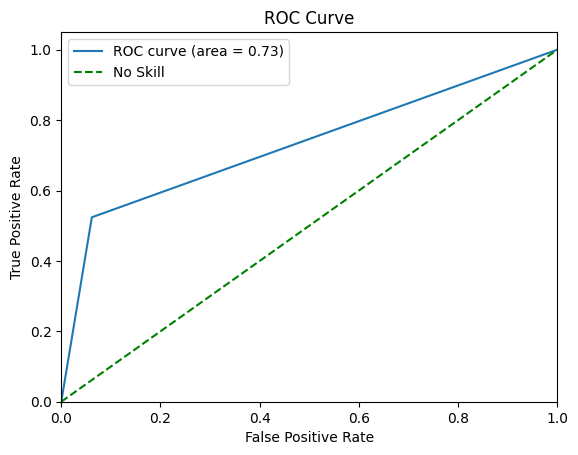

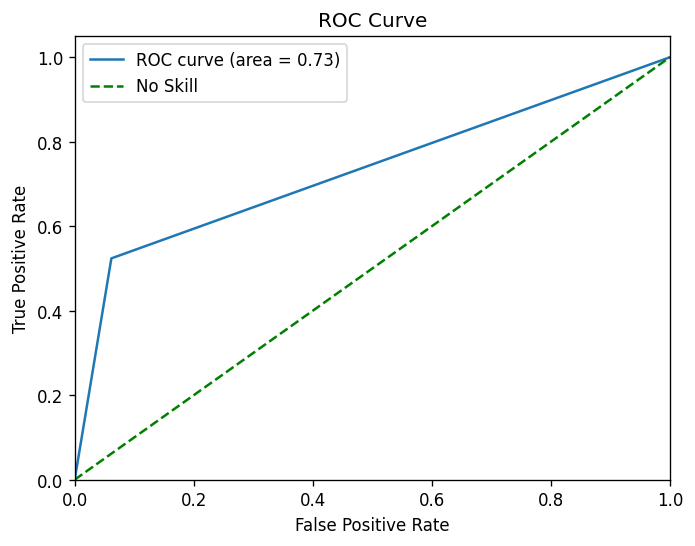

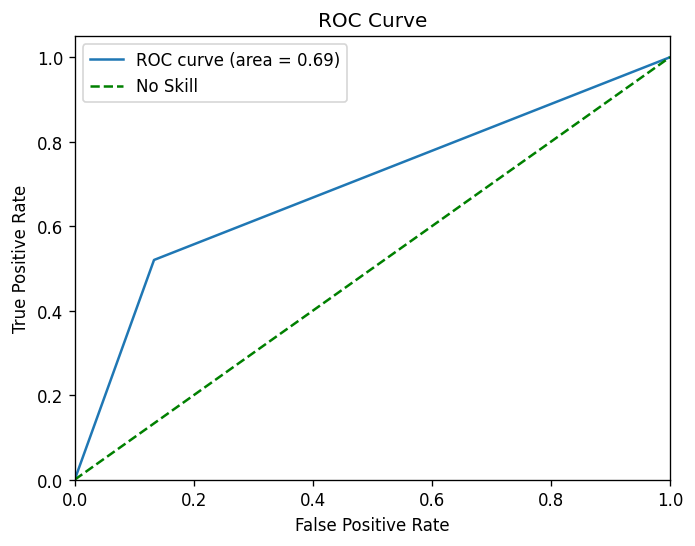

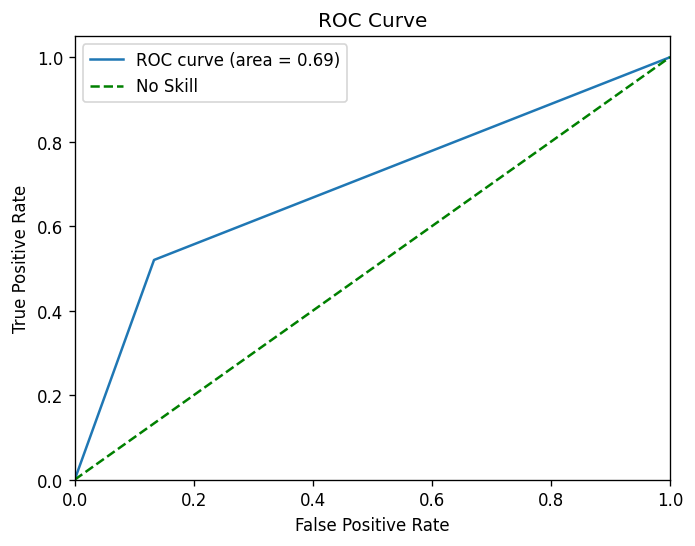

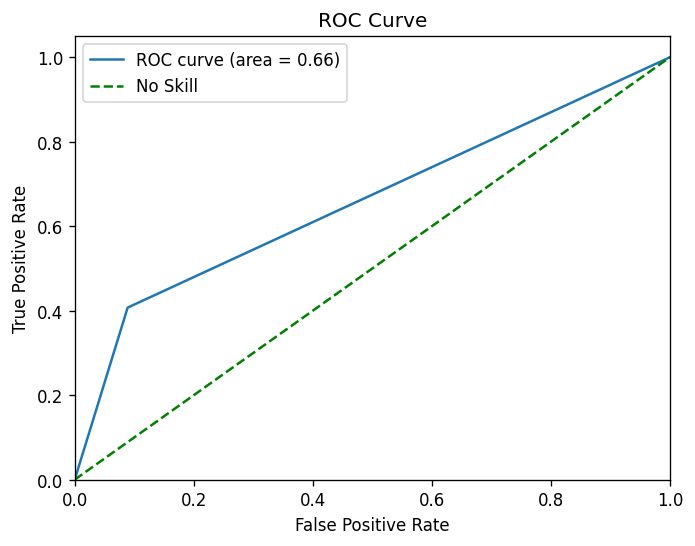

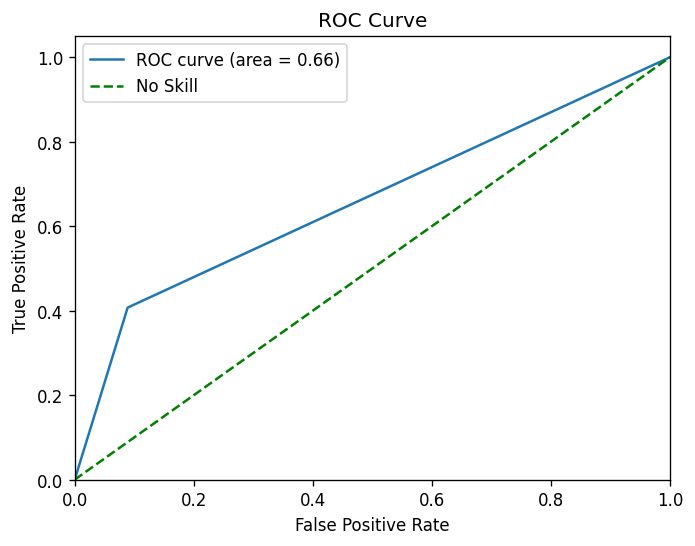

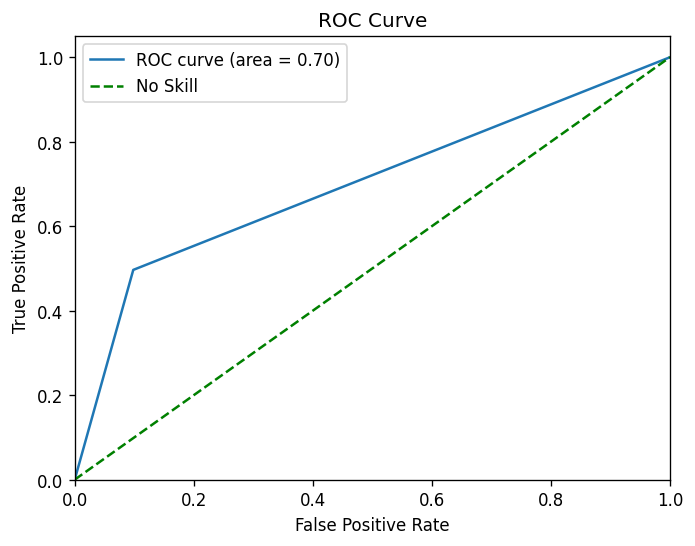

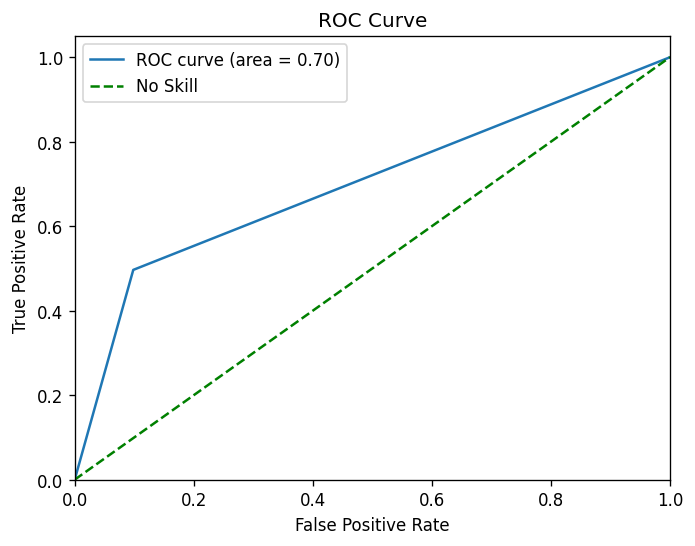

In [ ]:
R_LSTM, cm_LSTM, result_F,ifold_LSTM = model_kfold_SF(df_W, next_class, input_f=2, ep=num_epochs, bs=bach_size,
                                              path_file=path_file,model_name='LSTM')

--  --  --  --  --   i_fold: 0 0
 	 	 	 	 	 	  num_class: [array([[27654]]), array([[8172]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
 	 	 	 	 	 	  num_class: [array([[30555]]), array([[5268]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
orginal_data:  (30994, 24, 2) (30994, 1, 1) (35823, 24, 2) (35823, 1, 1)
[0 1] 439 [0 1] 5268
--..--..--..--..--..--..--..--..--..--..--..--..


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 24, 2)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decomposition_block       │ [(None, 24, 2), (None, │              0 │ input_layer_4[0][0]    │
│ (DecompositionBlock)      │ 24, 2)]                │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 2)          │              0 │ decomposition_block[0… │
│                           │                        │                │ decomposition_block[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 24, 1)          │              3 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_16 (LSTM)            │ (None, 2)              │             32 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 60)             │            180 │ lstm_16[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 30)             │          1,830 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │             31 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,076 (8.11 KB)

 Trainable params: 2,076 (8.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.7708 - loss: 0.5829
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7729 - loss: 0.5342
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7915 - loss: 0.4807
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8272 - loss: 0.4076
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8269 - loss: 0.4007
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8263 - loss: 0.3979
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8266 - loss: 0.3931
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8236 - loss: 0.4002
Epoch 9/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8297 - loss: 0.3950
Epoch 10/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8350 - loss: 0.3840
Epoch 11/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8291 - loss: 0.3906
Epoch 12/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 

<ipython-input-37-91ddcc29d7c3>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_model = pd.concat([result_model, result])


------------------------------      ------------------------------      
--  --  --  --  --   i_fold: 1 0
 	 	 	 	 	 	  num_class: [array([[58209]]), array([[13440]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
 	 	 	 	 	 	  num_class: [array([[29571]]), array([[6252]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
orginal_data:  (30092, 24, 2) (30092, 1, 1) (35823, 24, 2) (35823, 1, 1)
[0 1] 521 [0 1] 6252
--..--..--..--..--..--..--..--..--..--..--..--..


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 24, 2)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decomposition_block_1     │ [(None, 24, 2), (None, │              0 │ input_layer_5[0][0]    │
│ (DecompositionBlock)      │ 24, 2)]                │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 24, 2)          │              0 │ decomposition_block_1… │
│                           │                        │                │ decomposition_block_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 24, 1)          │              3 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_17 (LSTM)            │ (None, 2)              │             32 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 60)             │            180 │ lstm_17[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 30)             │          1,830 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             31 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,076 (8.11 KB)

 Trainable params: 2,076 (8.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8091 - loss: 0.5281
Epoch 2/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8546 - loss: 0.3702
Epoch 3/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8598 - loss: 0.3480
Epoch 4/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8609 - loss: 0.3377
Epoch 5/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8630 - loss: 0.3325
Epoch 6/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8571 - loss: 0.3427
Epoch 7/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8619 - loss: 0.3330
Epoch 8/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8621 - loss: 0.3332
Epoch 9/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8629 - loss: 0.3308
Epoch 10/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8637 - loss: 0.3281
Epoch 11/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8634 - loss: 0.3286
Epoch 12/30
560/560 ━━━━━━━━━━━━━━━

<ipython-input-37-91ddcc29d7c3>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_model = pd.concat([result_model, result])


------------------------------      ------------------------------      
--  --  --  --  --   i_fold: 2 0
 	 	 	 	 	 	  num_class: [array([[87780]]), array([[19692]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
 	 	 	 	 	 	  num_class: [array([[30255]]), array([[5568]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
orginal_data:  (30719, 24, 2) (30719, 1, 1) (35823, 24, 2) (35823, 1, 1)
[0 1] 464 [0 1] 5568
--..--..--..--..--..--..--..--..--..--..--..--..


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 24, 2)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decomposition_block_2     │ [(None, 24, 2), (None, │              0 │ input_layer_6[0][0]    │
│ (DecompositionBlock)      │ 24, 2)]                │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 24, 2)          │              0 │ decomposition_block_2… │
│                           │                        │                │ decomposition_block_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 24, 1)          │              3 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_18 (LSTM)            │ (None, 2)              │             32 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 60)             │            180 │ lstm_18[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 30)             │          1,830 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1)              │             31 │ dense_14[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,076 (8.11 KB)

 Trainable params: 2,076 (8.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.8149 - loss: 0.5157
Epoch 2/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8461 - loss: 0.3879
Epoch 3/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8508 - loss: 0.3666
Epoch 4/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8518 - loss: 0.3579
Epoch 5/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8531 - loss: 0.3525
Epoch 6/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8526 - loss: 0.3521
Epoch 7/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8549 - loss: 0.3483
Epoch 8/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.8552 - loss: 0.3472
Epoch 9/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8570 - loss: 0.3458
Epoch 10/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8591 - loss: 0.3411
Epoch 11/30
840/840 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8579 - loss: 0.3434
Epoch 12/30
840/840 ━━━━━━━━━━

<ipython-input-37-91ddcc29d7c3>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_model = pd.concat([result_model, result])


------------------------------      ------------------------------      
--  --  --  --  --   i_fold: 3 0
 	 	 	 	 	 	  num_class: [array([[118035]]), array([[25260]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
 	 	 	 	 	 	  num_class: [array([[30459]]), array([[5364]]), array([[0]]), array([[0]]), array([[0]]), array([[0]])]
orginal_data:  (30906, 24, 2) (30906, 1, 1) (35823, 24, 2) (35823, 1, 1)
[0 1] 447 [0 1] 5364
--..--..--..--..--..--..--..--..--..--..--..--..


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 24, 2)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decomposition_block_3     │ [(None, 24, 2), (None, │              0 │ input_layer_7[0][0]    │
│ (DecompositionBlock)      │ 24, 2)]                │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 24, 2)          │              0 │ decomposition_block_3… │
│                           │                        │                │ decomposition_block_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 24, 1)          │              3 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_19 (LSTM)            │ (None, 2)              │             32 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 60)             │            180 │ lstm_19[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 30)             │          1,830 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 1)              │             31 │ dense_18[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,076 (8.11 KB)

 Trainable params: 2,076 (8.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.8231 - loss: 0.4821
Epoch 2/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.8483 - loss: 0.3614
Epoch 3/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.8522 - loss: 0.3530
Epoch 4/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.8555 - loss: 0.3475
Epoch 5/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.8576 - loss: 0.3432
Epoch 6/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.8605 - loss: 0.3370
Epoch 7/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.8611 - loss: 0.3373
Epoch 8/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8627 - loss: 0.3356
Epoch 9/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8628 - loss: 0.3330
Epoch 10/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8642 - loss: 0.3331
Epoch 11/30
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8653 - loss: 0.3320
Epoch 12

<ipython-input-37-91ddcc29d7c3>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_model = pd.concat([result_model, result])


------------------------------      ------------------------------      


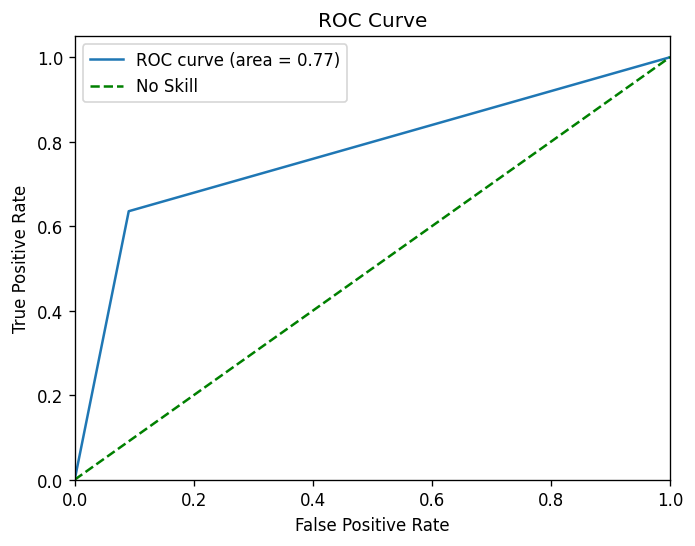

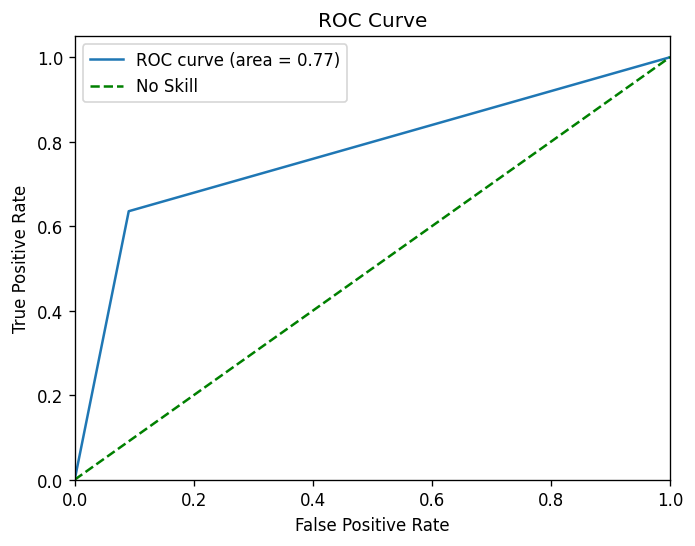

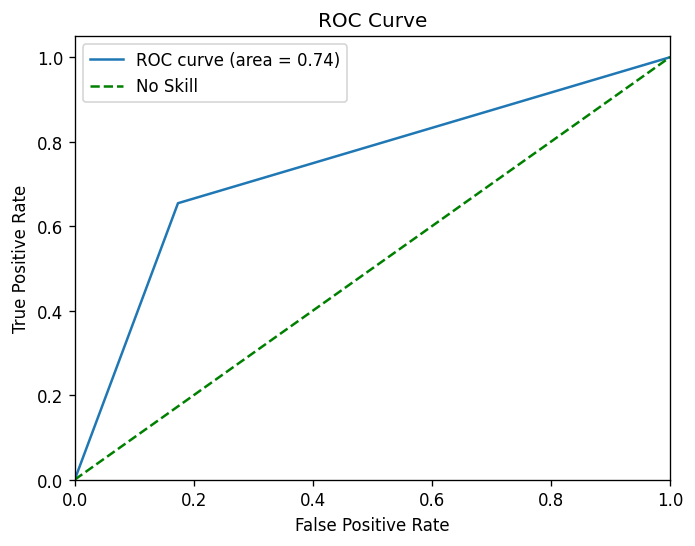

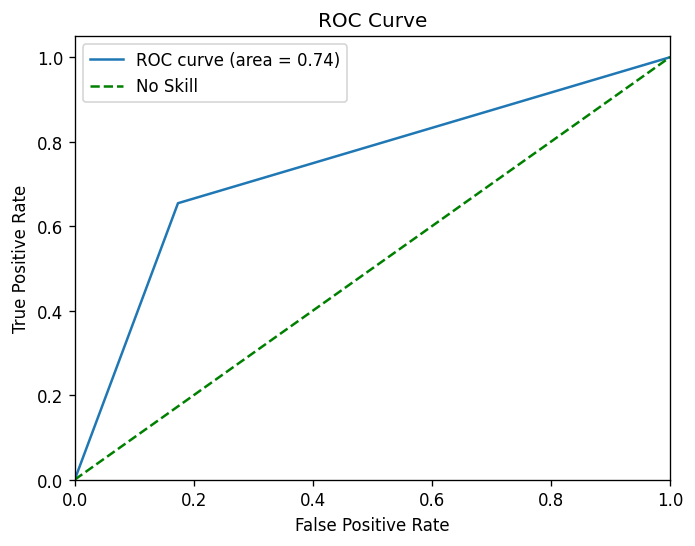

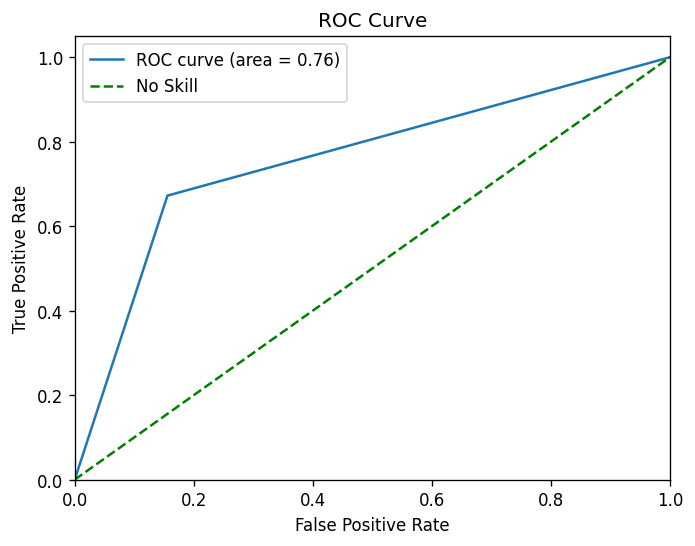

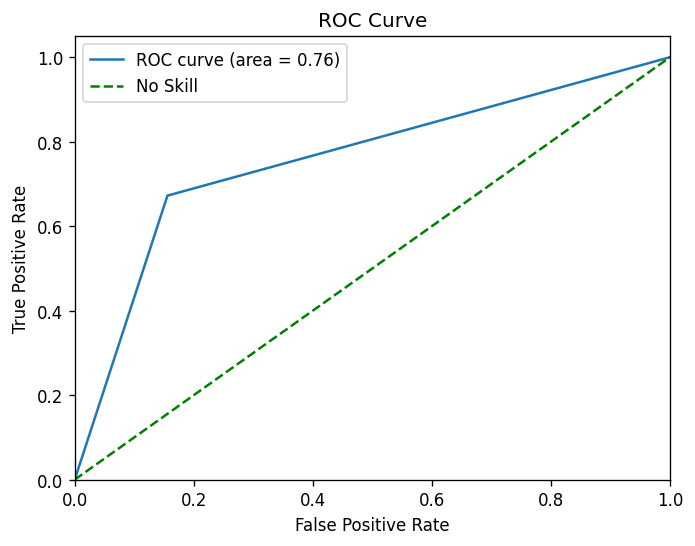

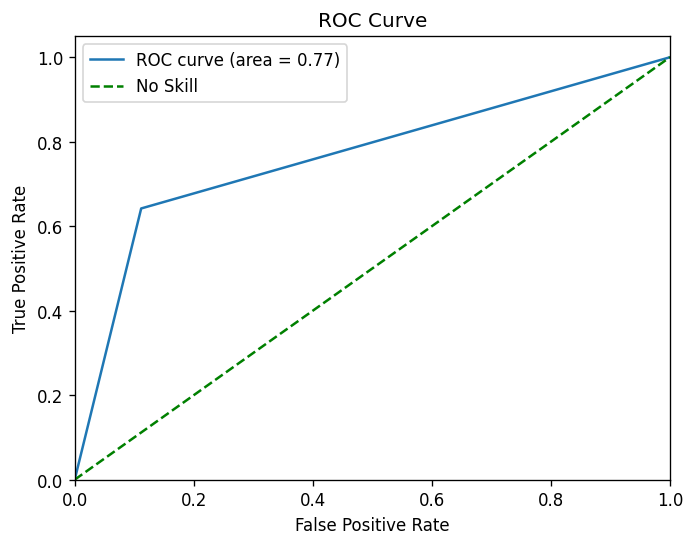

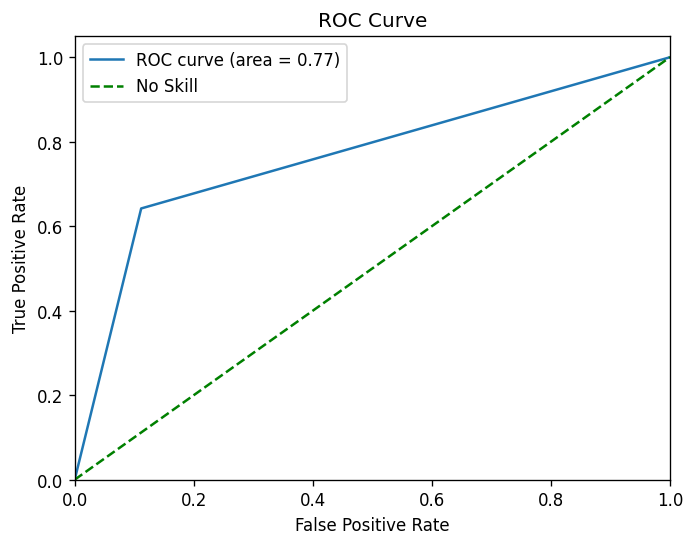

In [ ]:
R_LSTM, cm_LSTM, result_F,ifold_LSTM = model_kfold_SF(df_W, next_class, input_f=2, ep=num_epochs, bs=bach_size,
                                              path_file=path_file,model_name='D')